In [1]:
import os

import tensorflow as tf
import tensorflow.keras as keras

from keras_cv_attention_models import beit, convnext, swin_transformer_v2, davit, mobilevit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from collections import defaultdict
from tabulate import tabulate
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score

from datetime import datetime
from time import time
from time import sleep
import pytz

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [2]:
# orig_folder = "../datasets/original"
exp_folder = "./experiment"

# orig_dataset1 = os.path.join(orig_folder, "1")
# orig_dataset2 = os.path.join(orig_folder, "2/Training-validation")
# orig_dataset3 = os.path.join(orig_folder, "3")

exp_dataset1 = os.path.join(exp_folder, "1")
exp_dataset2 = os.path.join(exp_folder, "2")
exp_dataset3 = os.path.join(exp_folder, "3")

exp_dataset4 = os.path.join(exp_folder, "4")

exp_dataset5 = os.path.join(exp_folder, "5")

exp_dataset6 = os.path.join(exp_folder, "6")
exp_dataset7 = os.path.join(exp_folder, "7")
exp_dataset8 = os.path.join(exp_folder, "8")

CLASS_NAMES = ['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']

RANDOM_STATE = 42

randomiser = np.random.RandomState(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

def timer(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [3]:
"""
Gets the data from the specific path and stores the data as a tuple with its appropriate label
"""
def get_dataset(paths, class_names):
    full_data = []
    class_dict = {}
    for i, name in enumerate(class_names):
        class_dict[name] = i
    
    for path in paths:
        print(path)
        for d in class_names:
            # uncomment to use only four classes - for breastnet model
#             if d not in ['normal', 'csom', 'myringosclerosis', 'earwax']: continue
            dirpath = os.path.join(path, d)
            if not os.path.exists(dirpath): continue
            print(dirpath)
            image_files = [f for f in os.listdir(dirpath) if f.endswith(('.jpg', '.png', 'jpeg'))]
            label = d
            for img in image_files:
                image = Image.open(os.path.join(dirpath, img))

                image = np.asarray(image).astype(np.float32) / 255.0

                data = np.array([image, class_dict[label]], dtype=object)
                full_data.append(data)
    
    full_data = np.array(full_data)
    np.random.shuffle(full_data)
    return full_data

In [4]:
"""
Used to resize the image based on model input size
"""
def resize_image(image, size):
    image = tf.image.resize(np.asarray(image).astype('float32'), (size, size))
    return np.asarray(image).astype('float32')

In [5]:
# change base path depending on experiment
base_path = exp_dataset3

# uncomment depending on experiment
# class_names = ['normal', 'csom', 'myringosclerosis', 'earwax']

class_names = CLASS_NAMES

class_dict = {
    1: 'normal',
    2: 'aom',
    3: 'ome',
    4: 'csom',
    5: 'myringosclerosis',
    6: 'earwax',
    7: 'tube'
}

classes = [1, 4, 5, 6]
# classes = [2, 7]

classes = [1, 2, 3, 4, 5, 6, 7]

# classes = [1,3,7]

class_names = [class_dict[i] for i in classes]

validation_set = []
testing_set = []


if not base_path == (exp_dataset4) and not base_path == exp_dataset5 and False:
    class_names = [c for c in CLASS_NAMES if c in os.listdir(os.path.join(base_path, 'training'))]

    validation_set = get_dataset([os.path.join(base_path, 'validation')], class_names)
    testing_set = get_dataset([os.path.join(base_path, 'testing')], class_names)

elif base_path == exp_dataset5 and False:
    class_names = CLASS_NAMES
    validation_set = []
    testing_set = get_dataset([os.path.join(base_path, '1'), os.path.join(base_path, '2'), os.path.join(base_path, '3')], class_names)
else:
    # change start and end to save subsets of the dataset
    
    base_path = "./experiment"
    
    start = 1
    end = 4
    
    validation_paths = [os.path.join(base_path, f'{i}/validation') for i in range(start, end)]
    test_paths = [os.path.join(base_path, f'{i}/testing') for i in range(start, end)]

    validation_set = get_dataset(validation_paths, class_names)
    testing_set = get_dataset(test_paths, class_names)   


./experiment/1/validation
./experiment/1/validation/normal
./experiment/1/validation/ome
./experiment/1/validation/tube
./experiment/2/validation
./experiment/2/validation/normal
./experiment/2/validation/csom
./experiment/2/validation/myringosclerosis
./experiment/2/validation/earwax
./experiment/3/validation
./experiment/3/validation/normal
./experiment/3/validation/aom
./experiment/3/validation/csom
./experiment/3/validation/myringosclerosis
./experiment/3/validation/earwax
./experiment/3/validation/tube
./experiment/1/testing
./experiment/1/testing/normal
./experiment/1/testing/ome
./experiment/1/testing/tube
./experiment/2/testing
./experiment/2/testing/normal
./experiment/2/testing/csom
./experiment/2/testing/myringosclerosis
./experiment/2/testing/earwax
./experiment/3/testing
./experiment/3/testing/normal
./experiment/3/testing/aom
./experiment/3/testing/csom
./experiment/3/testing/myringosclerosis
./experiment/3/testing/earwax
./experiment/3/testing/tube


In [6]:
# Separate the full data containing images and labels inside tuples into a train and test set
X_val = np.array([x[0] for x in validation_set], dtype=object)
y_val = np.array([y[1] for y in validation_set], dtype=np.uint8)

X_test = np.array([x[0] for x in testing_set], dtype=object)
y_test = np.array([y[1] for y in testing_set], dtype=np.uint8)

In [7]:
# Used to check the sample size for the different classes
print(class_names)
print(np.bincount(y_val))
print(np.bincount(y_test))
print(sum(np.bincount(y_test)))

['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[93 11 18 28 25 36 11]
[188  25  36  57  49  72  23]
450


In [8]:
"""
Takes the history from training the model and graphs accuracy vs epoch and loss vs epoch
"""
def draw_graph(history):

    if 'history' in history:
        history = history.history
        
    plt.figure(figsize=(8,5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    best_epoch = np.argmin(history['val_loss'])
    
    plt.axvline(x=best_epoch, color='r', linestyle='--')
    plt.text(min(best_epoch+1, 38), 0.7, f"best epoch = {best_epoch}")

    plt.show()
    
    plt.figure(figsize=(8,5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    best_epoch = np.argmin(history['val_loss'])
    
    
    plt.axvline(x=best_epoch, color='r', linestyle='--')
    plt.text(min(best_epoch+1, 38), 0.9, f"best epoch = {best_epoch}")


In [9]:
"""
Compute the statistics, binary accuracy, accuracy, sensitivity, specificity and ppv
"""

def get_metrics(matrix):
    b_acc = []
    acc = []
    sens = []
    spec = []
    ppv = []

    for i, c in enumerate(class_names[:len(matrix)]):
        TP = matrix[i][i]
        FN = matrix.sum(axis=1)[i] - TP
        FP = matrix.sum(axis=0)[i] - TP
        TN = matrix.sum() - TP - FN - FP
        
        # Only use classes with a support greater than 0
        if (matrix.sum(axis=1)[i]) < 1: continue

        b_acc.append((TP+TN) / (TP+FN+FP+TN))
        acc.append((TP) / (TP+FN+FP+TN))
        sens.append((TP) / (TP+FN))
        spec.append((TN) / (TN+FP))
        ppv.append((TP) / (TP + FP))

    print(f"b_acc: {np.nanmean(b_acc)}")
    print(f"acc: {np.sum(acc)}")
    print(f"sens: {np.nanmean(sens)}")
    print(f"spec: {np.nanmean(spec)}")
    print(f"ppv: {np.nanmean(ppv)}")
    f1 = 2*(np.nanmean(ppv)*np.nanmean(sens) / (np.nanmean(ppv) + np.nanmean(sens)))
    print(f"f1: {f1}")

In [10]:
"""
Show the statistics of the model
Shows the confusion matrics and the selected metrics
"""

def show_statistics(model, X_test=X_test, y_test=y_test):
    # predict on the testing set to obtain a probability for each class
    y_pred=model.predict(X_test)
#     print(y_pred[0])
    
#     Uncomment to see the top-2 accuracy probability and value
#     print(top_k_accuracy_score(y_test, y_pred, k=2))
#     print(top_k_accuracy_score(y_test, y_pred, k=2, normalize=False))
    
        # use the highest probability to obtain the actual prediction
    y_pred=np.argmax(y_pred,axis=1)
    
    # display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    names = [class_names[i] for i in sorted(np.unique(y_test))]
    
#     print(np.unique(y_test))
#     names = class_names
#     print(names)
#     names = ['normal', 'aom', 'csom', 'myringosclerosis', 'earwax']
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=names)
    
    plt.rcParams["figure.figsize"] = (5,5)
    disp.plot(cmap="Greys", xticks_rotation="vertical")
    
    # Print table of metrics and evaluations
    print(classification_report(y_test, y_pred, target_names=names, zero_division=0))
    
    # Show model summary
#     model.summary()
    get_metrics(cm)


In [11]:
# the names of the models for the experiments
# though the names are the same right now, they don't need to be
# models = {
#     exp_dataset1: ['daViT_B', 'convBase', 'vgg19', 'MobileViT_S'],
#     exp_dataset2: ['daViT_B', 'convBase', 'vgg19', 'MobileViT_S'],
#     exp_dataset3: ['daViT_B', 'convBase', 'vgg19', 'MobileViT_S'],
#     exp_dataset4: ['daViT_B', 'convBase', 'vgg19', 'MobileViT_S']
# }


m = "daViT_B"
model_path = "./models/9"

In [12]:
# see the summary of a model

# base_path = base_path
# base_path = exp_dataset4

# base_path = model_path

# for m in models[base_path][3:4]:
#     print(m)
# model_path = base_path.replace('datasets/experiment', 'models')
model = keras.models.load_model(os.path.join(model_path, m), compile=False)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_pad (ZeroPadding2D)        (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 56, 56, 128)  18944       stem_pad[0][0]                   
__________________________________________________________________________________________________
stem_ln (LayerNormalization)    (None, 56, 56, 128)  256         stem_conv[0][0]                  
______________________________________________________________________________________________

Total params: 87,061,511
Trainable params: 87,061,511
Non-trainable params: 0
__________________________________________________________________________________________________


daViT_B
                  precision    recall  f1-score   support

          normal       0.89      0.90      0.90       188
             aom       0.64      0.72      0.68        25
             ome       0.92      0.97      0.95        36
            csom       0.98      0.81      0.88        57
myringosclerosis       0.81      0.88      0.84        49
          earwax       0.87      0.92      0.89        72
            tube       1.00      0.83      0.90        23

        accuracy                           0.88       450
       macro avg       0.87      0.86      0.86       450
    weighted avg       0.89      0.88      0.88       450

b_acc: 0.9657142857142856
acc: 0.88
sens: 0.8597829399844581
spec: 0.9769930174262347
ppv: 0.8737935543171235
f1: 0.8667316308680296


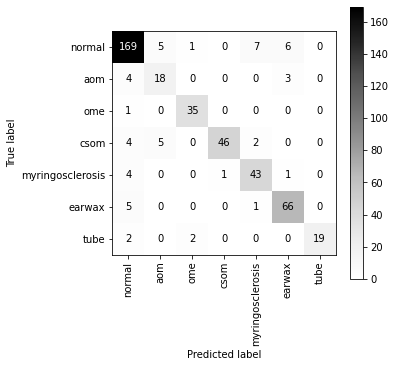

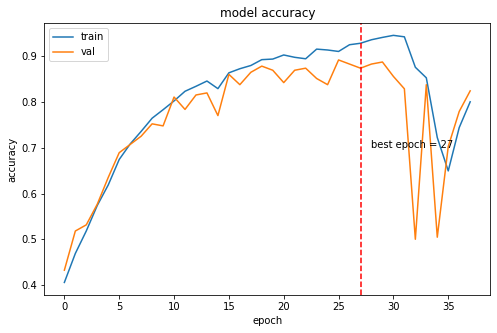

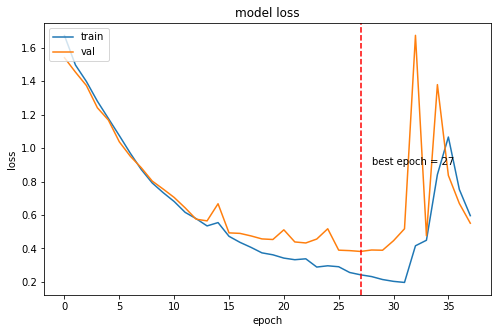

In [13]:
# change loop condition depending the model you want to test
# for m in models[base_path][3:4]:
#     model_path = base_path.replace('datasets/experiment', 'models')
    
    model = keras.models.load_model(os.path.join(model_path, m), compile=False)
    hist = np.load(os.path.join(model_path, m + '.npy'), allow_pickle='TRUE').item()
    
    # resize images according to input layer
    img_size = model.layers[0].input_shape[0][1]
    X_val2 = np.array([resize_image(x, img_size) for x in X_val])
    X_test2 = np.array([resize_image(x, img_size) for x in X_test])
    
    print(m)
    show_statistics(model, X_test2, y_test)
    
    
    draw_graph(hist)
    


In [14]:
"""
Creates the gradcam heatmap using last convolutional layer of the model
Code retrieved from https://keras.io/examples/vision/grad_cam/
"""

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



In [15]:
import matplotlib.cm as cm
import colorsys
"""
Takes an image and calls make_gradcam_heatmap() to make a 
heatmap then superimposes it to original image
"""
def display_gradcam(img, heatmap, alpha=0.5):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    si = []
    for j, y in enumerate(jet_heatmap):
        si.append([])
        for i, x in enumerate(jet_heatmap[j]):
            arr = jet_heatmap[j, i]
            hsv = colorsys.rgb_to_hsv(arr[0]/255.0, arr[1]/255.0, arr[2]/255.0)
            
            # removing non important colours
            if 150 < hsv[0]*360 < 250:
                si[j].append(arr * 0)
            else:
                si[j].append(arr * alpha)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = si + img

    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img, scale=True)

    # Display Grad CAM
    return superimposed_img



In [17]:
"""
Provide the index value of the specific class you want to see a visualisation of
i.e., a 'tube' class is index 6 in the variable CLASS_NAMES
The index value depends on the dataset and class names being used
"""
model = keras.models.load_model('./models/9/daViT_B', compile=False);

def find_id(idx, arr, s):
    for i in range(len(arr)):
        if arr[i] == idx: 
            if not i in s:
                return i
    return 0
    
s = set()
while True:
    x = int(input())
    if x == -1:
        break;
    
    num = find_id(x, y_test, s)
    s.add(num)
    img = X_test2[num]
    
#     change input shape as per model
    img = img.reshape((1, 224, 224, 3))
    
#     change layer name as per model
    heatmap = make_gradcam_heatmap(img, model, 'stack4_block2_output')
    print(class_names[y_test[num]], num)

    y_pred=model.predict(img)
    y_pred=np.argmax(y_pred,axis=1)[0]
    print("Predicted: " + class_names[y_pred])

    gradcam = display_gradcam(X_test2[num], heatmap, alpha=0.5)
    plt.imshow(gradcam)
    plt.show()

l


ValueError: invalid literal for int() with base 10: 'l'

./experiment/heatmap
./experiment/heatmap/normal
./experiment/heatmap/aom
./experiment/heatmap/ome
./experiment/heatmap/csom
./experiment/heatmap/myringosclerosis
./experiment/heatmap/earwax
./experiment/heatmap/tube
Predicted: normal
Expected: normal
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[51.188451051712036, 43.221572041511536, 0.49086716026067734, 1.615656167268753, 0.3250254550948739, 2.2659512236714363, 0.8924746885895729]


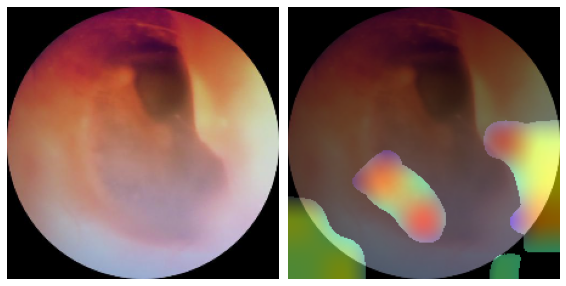

Predicted: earwax
Expected: earwax
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[0.16895952867344022, 0.13632691698148847, 1.2644724920392036, 0.7276501972228289, 0.3007908584550023, 96.18397951126099, 1.217813417315483]


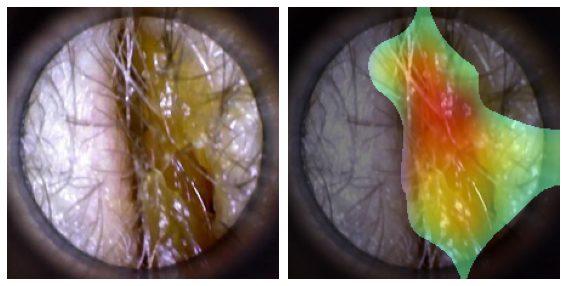

Predicted: aom
Expected: aom
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[3.020482510328293, 78.80263924598694, 1.025376096367836, 6.824137270450592, 1.1497053317725658, 3.876463696360588, 5.3011976182460785]


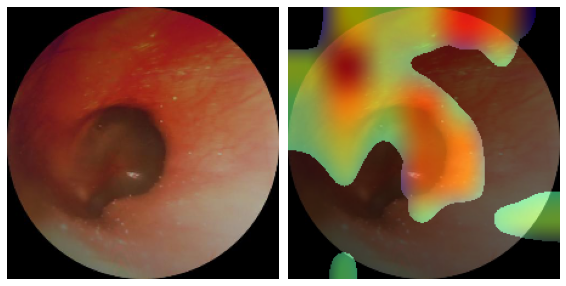

Predicted: normal
Expected: normal
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[98.63917827606201, 0.10584642877802253, 0.7604223676025867, 0.0286173599306494, 0.1084972987882793, 0.06861557485535741, 0.28881870675832033]


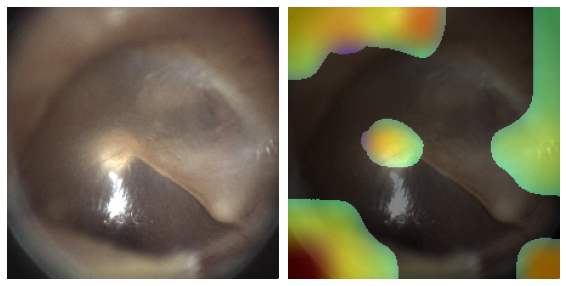

Predicted: csom
Expected: csom
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[15.343745052814484, 6.116855889558792, 0.5227812565863132, 61.837953329086304, 7.98509418964386, 6.4107827842235565, 1.7827799543738365]


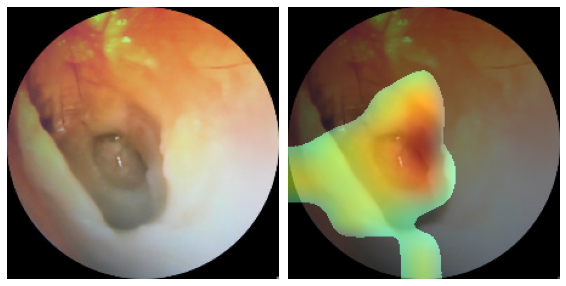

Predicted: normal
Expected: tube
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[97.08684086799622, 0.8157988078892231, 0.10573854669928551, 0.10668640024960041, 0.3678978653624654, 1.4298297464847565, 0.08720208425074816]


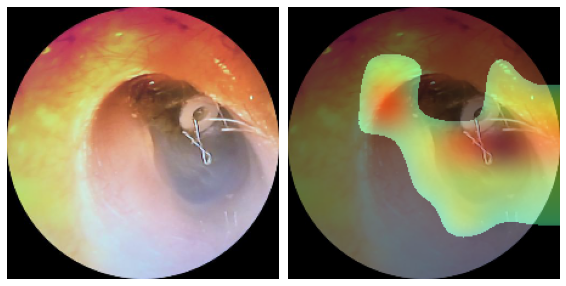

Predicted: csom
Expected: csom
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[0.008380096551263705, 0.6225999910384417, 2.3274775594472885, 95.63145637512207, 0.3779335180297494, 0.2878030529245734, 0.7443531416356564]


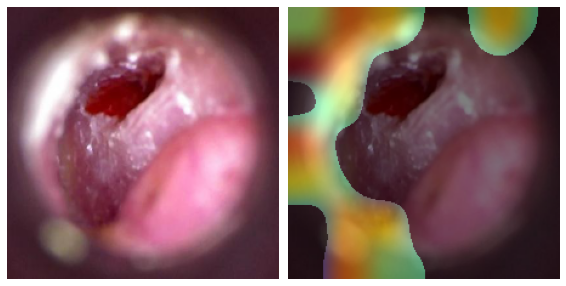

Predicted: myringosclerosis
Expected: myringosclerosis
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[0.39099855348467827, 0.06521596806123853, 0.09878509445115924, 1.8578287214040756, 95.6449031829834, 1.808464154601097, 0.1338035101071]


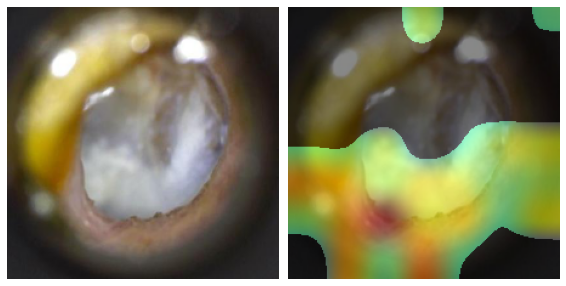

Predicted: normal
Expected: normal
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[97.27789163589478, 0.040651875315234065, 0.03643027157522738, 0.040738945244811475, 2.518586441874504, 0.04075909673701972, 0.04493641608860344]


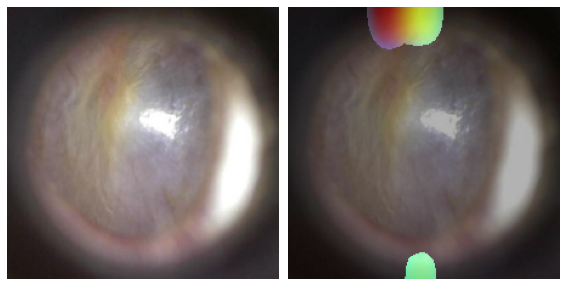

Predicted: normal
Expected: myringosclerosis
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[61.420828104019165, 7.399142533540726, 0.20275949500501156, 17.630741000175476, 10.69968268275261, 1.8287941813468933, 0.8180525153875351]


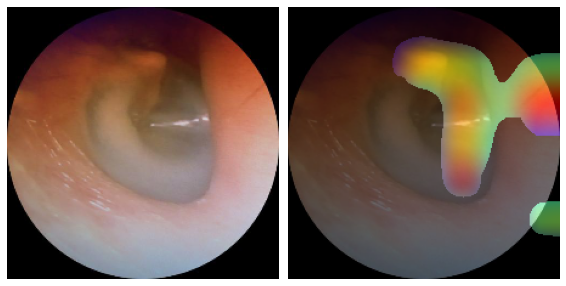

Predicted: earwax
Expected: earwax
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[0.5514323245733976, 0.34708918537944555, 0.39295339956879616, 0.14119615079835057, 0.15839668922126293, 97.42432832717896, 0.9845989756286144]


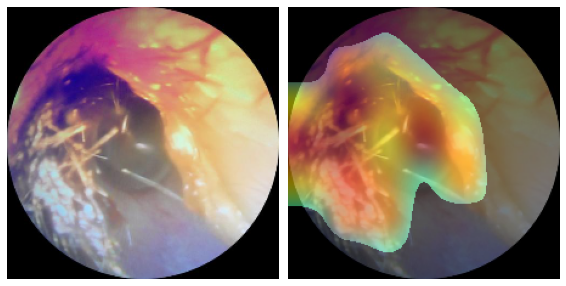

Predicted: ome
Expected: ome
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[1.7305320128798485, 0.4783755633980036, 96.56901955604553, 0.10461339261382818, 0.10332941310480237, 0.31698718667030334, 0.6971463561058044]


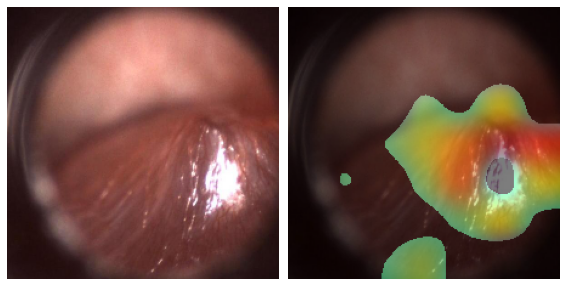

Predicted: tube
Expected: tube
['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
[27.192503213882446, 1.4046140015125275, 10.075462609529495, 1.8605053424835205, 1.8136333674192429, 0.6522320210933685, 57.00104832649231]


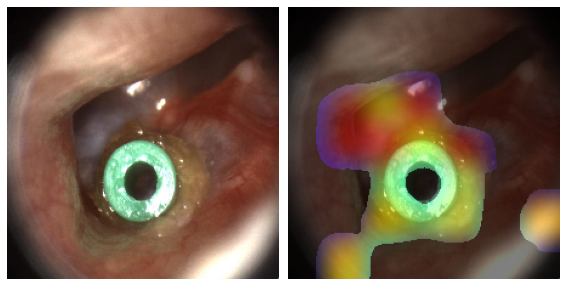

In [27]:
"""
Tests the model visualisation on some selected images
"""

# model = keras.models.load_model('./models/9/daViT_B', compile=False);

# get img size from model input layer
img_size = model.layers[0].input_shape[0][1]
CLASS_NAMES = ['normal', 'aom', 'ome', 'csom', 'myringosclerosis', 'earwax', 'tube']
image_files = get_dataset(['./experiment/heatmap'], CLASS_NAMES)

classes = CLASS_NAMES
for data in image_files:
    image = data[0]
    label = CLASS_NAMES[data[1]]
    
    image = resize_image(image, img_size)
    
    img = image.reshape((1, img_size, img_size, 3))
    heatmap = make_gradcam_heatmap(img, model, 'stack4_block2_output')

    y_pred=model.predict(img)
    y_pred2=np.argmax(y_pred,axis=1)[0]
    print("Predicted: " + classes[y_pred2])
    print("Expected: " + label)
    print(classes)
    print([float(a)*100 for a in y_pred[0]])

    gradcam = display_gradcam(image, heatmap, alpha=1)
    
#     uncomment to show original image
#     plt.imshow(image)
#     plt.axis('off')
#     plt.imshow(gradcam) 
#     plt.show()

    plt.figure(figsize=(10, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
#     plt.title('Original Image')

    # Plot the GradCAM heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(gradcam)
    plt.axis('off')
#     plt.title('GradCAM Heatmap')

    plt.subplots_adjust(wspace=0.01)
    # Add a caption for the combined image at the bottom
#     plt.suptitle(f"{label}", y=0.05, fontsize=16)

    plt.show()
               

In [25]:
"""
Loads the breastnet / omnet model to use for testing
The test set can only contain the classes - normal, aom, csom, earwax
"""


omnet_model_name = 'BREASTNET_FOLD_3.h5'
omnet_model = keras.models.load_model(os.path.join('../models', omnet_model_name), compile=False)

img_size = model.layers[0].input_shape[0][1]
X_val2 = np.array([resize_image(x, img_size) for x in X_val])
X_test2 = np.array([resize_image(x, img_size) for x in X_test])

print(omnet_model_name)
show_statistics(omnet_model, X_test2, y_test)